In [ ]:
"""
CONNECT WITH DRIVE
"""

%pip install gdown
import gdown
import os
import shutil
from google.colab import drive

# Drive
drive.mount('/content/drive')

# url = 'https://drive.google.com/uc?id=1AvXhv8p9ZCUZ2dzbYoA5CP8VT7a8b6Gf' # full
url = 'https://drive.google.com/uc?id=1c4n7GXPn0OTgUsPJwuWWnIignXXJDm6W' # train
url_test = 'https://drive.google.com/uc?id=1PNLYjJ9lGwn2bie2EkVaF1Qw5IcY7rov' # test


output = 'dataset_nonrandom_responses.pth'

gdown.download(url, output, quiet=False)
gdown.download(url_test, f'{output}_test', quiet=False)

# Github
!git clone https://github.com/karolrogozinski/cern_alice_fast_sim_corrvae.git

source = '/content/cern_alice_fast_sim_corrvae'
destination = '/content'

for file in os.listdir(source):
    source_path = os.path.join(source, file)
    dest_path = os.path.join(destination, file)

    try:
        shutil.copy(source_path, dest_path)
    except IsADirectoryError:
        shutil.copytree(source_path, dest_path)


In [1]:
"""
CorrVAE training based on [TODO]
"""

import time

import numpy as np
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch import optim

from model import ControlVAE
from encoders import EncoderControlVAE
from decoders import DecoderControlVAE

from utils.helpers import plot_epoch, save_model
from utils.loss import get_losses


In [2]:
"""
PROPERTIES
All of them are normalized

0. - x coordinate of max pixel
1. - y coordinate of max pixel
2. - x coordinate of mass center
3. - y coordinate of mass center
4. - number of non zero pixels
5. - categorized number of non zero pixels
6. - sum of pixels over the treshold !DONT USE IT
7. - sum of pixels
8. - max pixel value
"""

properties = [2, 3]
properties_cond = [7, 8]


In [3]:
"""
ARGUMENTS
"""

device = 'cpu'

results_dir = '/content/drive/MyDrive/models/'
data_source = './data/dataset_nonrandom_responses_train.pth'

img_size = (1, 44, 44)
latent_dim = 8
latent_dim_prop = 8
latent_dim_cond = 8
cond_dim = 9

hid_channels = 64

num_prop = len(properties)
num_prop_cond = len(properties_cond)

lr = 1e-4

batch_size = 64
epochs = 250

beta = 1
taus = 0.2
idx_kl = 0
w_kl = 100

lambdas = [
    1000000,    # reconstruction_loss
    1,          # pairwise_tc_loss
    1000000,    # reconstruction_prop_loss
    1,          # kl_loss
    1,          # groupwise_wz_loss
    1,          # groupsize_wc_loss
    1000000,    # reconstruction_prop_cond_loss
    1,          # groupwise_cz_loss
]


In [ ]:
"""
WANDB LOGGER
"""
try:
    import wandb
except:
    %pip install wandb
    import wandb


In [ ]:
token = ...
wandb.login(key=token, relogin=True)


In [ ]:
wandb.init(
    project="CorrVAE_64x64",

    config={
        # "data size": train_size,
        "batch_size": batch_size,
        "beta": beta,
        "taus": taus,
        "loss func": 'sigmoid',
        "lr": lr,
        "num prop": num_prop,
        "latent_dim": latent_dim,
        "latent_dim_prop": latent_dim_prop
    }
)


In [4]:
"""
DATA
"""

data = torch.load(data_source)
dataset = TensorDataset(data['features'], data['labels'])

train_loader = DataLoader(dataset, shuffle=True, batch_size=batch_size)


data_test = torch.load(f'{data_source}_test')
dataset_test = TensorDataset(data_test['features'], data_test['labels'])

test_loader = DataLoader(dataset_test, shuffle=True, batch_size=batch_size)


FileNotFoundError: [Errno 2] No such file or directory: './data/dataset_nonrandom_responses_train.pth_test'

In [5]:
"""
MODEL
"""

encoder = eval("EncoderControlVAE")
decoder = eval("DecoderControlVAE")

model = ControlVAE(img_size, encoder, decoder, latent_dim, latent_dim_prop,
                   latent_dim_cond, cond_dim, num_prop, num_prop_cond, device=device)
model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=lr)

lr_scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer,
        milestones=[50, 100, 150, 200],
        gamma=0.1
)

mse_loss = torch.nn.MSELoss(reduction="sum")

recon_loss_prop_rec = []
recon_loss_rec = []
kl_loss_rec = []
pwwi_loss_rec = []
pwz_loss_rec = []
l1_loss_rec = []
mask_rec = []


In [6]:
start_epoch = time.time()

for epoch in range(epochs):
    if (epoch + 1) % 10 == 0:
        taus = taus * 0.1

    epoch_loss = []
    epoch_kl_loss = []
    epoch_rec_loss = []
    epoch_prop_loss = []
    epoch_prop_cond_loss = []
    epoch_pairwise_loss = []
    epoch_groupwise_loss = []
    epoch_groupwise_cond_loss = []
    epoch_groupwise_cz_loss = []
    epoch_l1_norm = []
    epoch_total_q = []

    for (data, label) in tqdm(train_loader):
        idx_kl += 1
        data = data.to(device)
        cond = label[:,9:].to(device)

        (reconstruct, y_reconstruct, y_cond_reconstruct), latent_dist_z, latent_dist_w, latent_dist_c, \
            latent_sample_z, latent_sample_w, latent_sample_c, mask, w_mask = model(data, cond, taus)

        latent_dist = (torch.cat([latent_dist_w[0], latent_dist_z[0], latent_dist_c[0]], dim=-1),
                       torch.cat([latent_dist_w[1], latent_dist_z[1], latent_dist_c[1]], dim=-1))

        ###### Reconstruction loss ######
        rec_loss = F.mse_loss(reconstruct, data, reduction="sum") / 64
        rec_loss = rec_loss / batch_size

        rec_loss_prop = []
        rec_loss_prop_cond = []

        for i, prop in enumerate(properties):
            rec_loss_prop.append(mse_loss(y_reconstruct[:,i], label[:, prop].float().to(device)))
        for i, prop in enumerate(properties_cond):
            rec_loss_prop_cond.append(mse_loss(y_cond_reconstruct[:,i], label[:, prop].float().to(device)))

        rec_loss_prop_all = sum(rec_loss_prop)
        rec_loss_prop_cond_all = sum(rec_loss_prop_cond)

        ####### Quasi WS loss ######
        sum_q1 = torch.sum(data[:22, :22]) - torch.sum(reconstruct[:22, :22])
        sum_q2 = torch.sum(data[:22, 22:]) - torch.sum(reconstruct[:22, 22:])
        sum_q3 = torch.sum(data[22:, :22]) - torch.sum(reconstruct[22:, :22])
        sum_q4 = torch.sum(data[22:, 22:]) - torch.sum(reconstruct[22:, 22:])

        total_q = sum_q1.abs() + sum_q2.abs() + sum_q3.abs() + sum_q4.abs()
        total_q /= 64


        ###### Other losses ######
        kl_loss, pairwise_tc_loss, groupwise_tc_loss, groupwise_tc_loss_cond, \
                groupwise_tc_loss_cz, l1norm, loss, w_kl = get_losses(
            latent_dist,
            latent_sample_w,
            latent_dist_w,
            beta,
            latent_sample_z,
            latent_dist_z,
            mask,
            device,
            idx_kl,
            rec_loss,
            rec_loss_prop_all,
            w_kl,
            len(train_loader.dataset),
            lambdas,
            latent_sample_c,
            latent_dist_c,
            rec_loss_prop_cond_all,
            total_q
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss.append(float(loss))
        epoch_kl_loss.append(float(kl_loss))
        epoch_rec_loss.append(float(rec_loss))
        epoch_prop_loss.append(float(rec_loss_prop_all))
        epoch_prop_cond_loss.append(float(rec_loss_prop_cond_all))
        epoch_pairwise_loss.append(float(pairwise_tc_loss))
        epoch_groupwise_loss.append(float(groupwise_tc_loss))
        epoch_groupwise_cond_loss.append(float(groupwise_tc_loss_cond))
        epoch_groupwise_cz_loss.append(float(groupwise_tc_loss_cz))
        epoch_l1_norm.append(float(l1norm))
        epoch_total_q.append(float(total_q))

    wandb.log(
        {"total_loss ": np.mean(epoch_loss),
            "KL_loss": np.mean(epoch_kl_loss),
            "rec_loss": np.mean(epoch_rec_loss),
            "rec_prop_loss": np.mean(epoch_prop_loss),
            "rec_prop_cond_loss": np.mean(epoch_prop_cond_loss),
            "wwi_loss": np.mean(epoch_pairwise_loss),
            "wz_loss": np.mean(epoch_groupwise_loss),
            "wc_loss": np.mean(epoch_groupwise_cond_loss),
            "cz_loss": np.mean(epoch_groupwise_cz_loss),
            "l1_norm": np.mean(epoch_l1_norm),
            "total_q": np.mean(epoch_total_q),
    })

    save_model(model, optimizer, results_dir, epoch)
    plot_epoch(test_loader, model, device, taus, epoch, time.time() - start_epoch)

    lr_scheduler.step()
    start_epoch = time.time()


  4%|▍         | 140/3699 [00:20<08:38,  6.86it/s]


KeyboardInterrupt: 

Completed Epoch 0  Time:  64.68347477912903


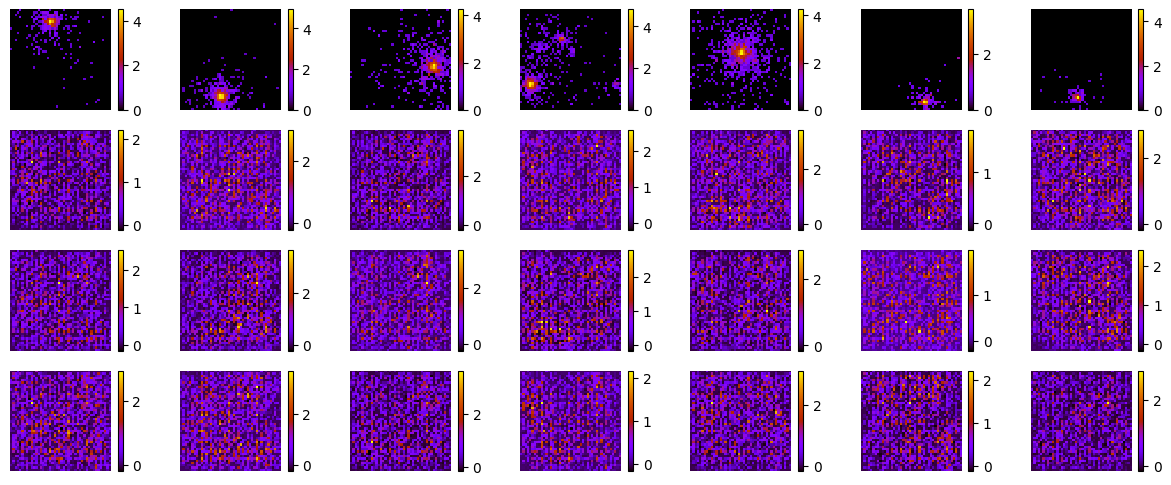

In [21]:
plot_epoch(train_loader, model, device, taus, epoch, time.time() - start_epoch)
